## 1. Requirements

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision import datasets, transforms

from advertorch.attacks import PGDAttack as PGD

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. MNIST model

In [2]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # mnist의 경우 28*28의 흑백이미지(input channel=1)이다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding=2)
        # feature map의 크기는 14*14가 된다
        # 첫번재 convolution layer에서 나온 output channel이 32이므로 2번째 input도 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding=2)
        # feature map의 크기는 7*7이 된다
        # fc -> fully connected, fc는 모든 weight를 고려해서 만들기 때문에 cnn에서는 locally connected를 이용하여 만든다.
        # nn.Linear에서는 conv를 거친 feature map을 1차원으로 전부 바꿔서 input을 한다. 이게 64*7*7
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) # linear에 들어갈 수 있도록 reshape
        x = F.relu(self.fc1(x)) # fully connected에 relu 적용
        x = F.dropout(x, training=self.training) # 가중치 감소만으로는 overfit을 해결하기가 어려움, 그래서 뉴런의 연결을 임의로 삭제
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 3. PGD attack

In [3]:
def pgd_attack(model, device, test_loader):
    print("Attack Image!!")
    adversary = PGD(model, loss_fn=nn.NLLLoss(reduction='sum'), 
                    eps=0.3, nb_iter=40, eps_iter=0.01, rand_init = True, 
                    clip_min=0., clip_max=1., targeted=False)
    perturbed_images = []
    # p_labels = []
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        perturbed_images.append((adversary.perturb(image, label), label))
    # perturbed_images = torch.cat(perturbed_images, dim=0)
    print("Attack Done!!")
    return perturbed_images

## 4. test function

In [4]:
def test(model, device, images, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # test set의 모든 예제를 test한다
    for image, label in images:
        # cpu나 gpu로 데이터를 전송한다
        image, label = image.to(device), label.to(device)

        # Re-classify the perturbed image
        output = model(image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == label.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = image.squeeze().detach().cpu().numpy()
                adv_examples.append( (label.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = image.squeeze().detach().cpu().numpy()
                adv_examples.append( (label.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    # final_acc = correct/idx
    final_acc = correct/float(len(images))
    # print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, idx, final_acc))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(images), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## 5. Load dataset and pretrained model, Set device

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

download_path = './data'
train_dataset = MNIST(download_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_path, transform=mnist_transform, train=False, download=True)

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print("CUDA Available:", is_cuda)

CUDA Available: True


In [7]:
# epsilons: 여러개로 input
# pretrained_model: 이전에 training한 mnist 모델
pretrained_model = './model/mnist_um.pth'
pgd_defense_model = './model/mnist_pgd_model.pth'

model_normal = MnistModel().to(device)
model_normal.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

model_pgd = MnistModel().to(device)
model_pgd.load_state_dict(torch.load(pgd_defense_model, map_location='cpu'))

<All keys matched successfully>

## 6. Run test for each epsilon

In [8]:
perturbed_images = pgd_attack(model_normal, device, test_loader)

Attack Image!!
Attack Done!!


In [9]:
normal_accuracies = []
pgd_accuracies = []
examples = []
epsilons = [.3]


print('Normal:')
for eps in epsilons:
    acc, ex = test(model_normal, device, perturbed_images, eps)
    normal_accuracies.append(acc)
    examples.append(ex)

print('PGD defense:')    
for eps in epsilons:
    acc, ex = test(model_pgd, device, perturbed_images, eps)
    pgd_accuracies.append(acc)

Normal:
Epsilon: 0.3	Test Accuracy = 29 / 10000 = 0.0029
PGD defense:
Epsilon: 0.3	Test Accuracy = 9424 / 10000 = 0.9424


# Results

## Accuracy vs Epsilon

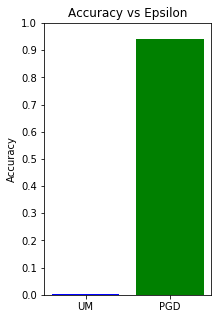

In [18]:
plt.figure(figsize=(3,5))
plt.bar(['UM'], normal_accuracies, label='UM', color='b')
plt.bar(['PGD'], pgd_accuracies, label='PGD', color='g')
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample FGSM examples

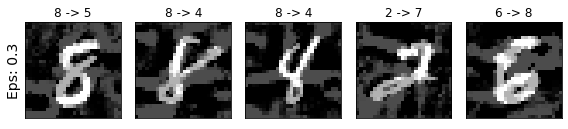

In [19]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()